In [2]:
import nibabel as nib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy

# Create 3D mask of the electrode positions
1. load mni file 
2. convert mni coordinates of the electrode positions into voxel space 
3. create mask for electrode positions
4. create sphere around each electrode position
5. safe as nifti file 

In [2]:
# load positions
figure_dir=f"/Users/kamp/PhD/spikevar/repo/SpikeVar/figures"
position_file=f"{figure_dir}/electrodePos_clean.csv"
positions = pd.read_csv(position_file, sep=";")
positions[positions=="n/a "] = np.NAN

n_patients = len(positions)
brain_regions = positions.columns[1:]

# load mni
mni_path = "/usr/local/fsl/data/standard/MNI152_T1_0.5mm.nii.gz"
mni_image = nib.load(mni_path)
aff = mni_image.affine # 0.5 space
mni_data = mni_image.get_fdata()

# mark voxels that contain an electrode
# create amygdala mask
amygdala_mask = np.zeros_like(mni_data)
for i in range(n_patients):
    for region in brain_regions[:-2]: 
        if not isinstance(positions.loc[i,region], str):
            continue
        mm_coordinates = [float(c) for c in positions.loc[i, region].replace(" ","").split(",")]
        # transform coordinates in voxel space
        x,y,z = np.array([int(c) for c in nib.affines.apply_affine(np.linalg.inv(aff), mm_coordinates)])
        # add value at electrode position
        amygdala_mask[x,y,z] = 1

# create hippocampus mask
hpc_mask = np.zeros_like(mni_data)
for i in range(n_patients):
    for region in brain_regions[2:]: 
        if not isinstance(positions.loc[i,region], str):
            continue
        mm_coordinates = [float(c) for c in positions.loc[i, region].replace(" ","").split(",")]
        x,y,z = np.array([int(c) for c in nib.affines.apply_affine(np.linalg.inv(aff), mm_coordinates)])
        hpc_mask[x,y,z] = 1

# create spheres around electrode positions
def create_sphere(size):
    x,y,z = np.mgrid[-size:size+1,-size:size+1,-size:size+1]
    mask = x**2 + y**2 + z**2 <= size**2
    return mask.astype('int')
sphere = create_sphere(4)

hpc_mask = scipy.ndimage.convolve(hpc_mask, weights = sphere)
amygdala_mask = scipy.ndimage.convolve(amygdala_mask, weights = sphere)

# binarize
hpc_mask[hpc_mask!=0]=1
amygdala_mask[amygdala_mask!=0]=1

# save as masks as nifti file 
hpc_nifti = nib.Nifti1Image(hpc_mask, aff, nib.Nifti1Header())
nib.save(hpc_nifti, "hpc_mask.nii.gz")
hpc_nifti = nib.Nifti1Image(amygdala_mask, aff, nib.Nifti1Header())
nib.save(hpc_nifti, "amygdaly_mask.nii.gz")

# Plot the electrode positions onto brain slice

[-21. -19. -17.]


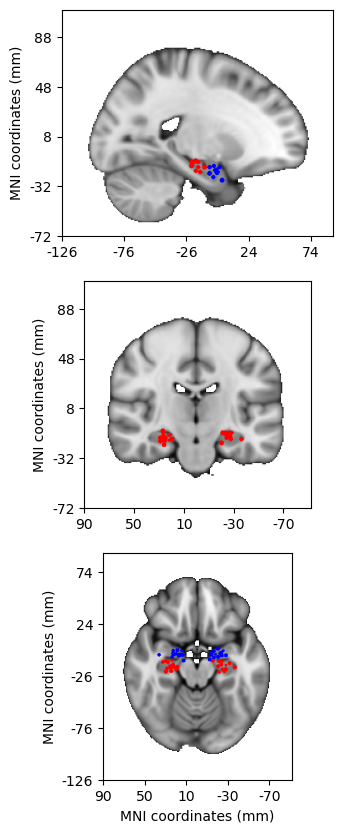

In [10]:
# create transparent to red colormap
colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmapred = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)
colors = [(0,0,1,c) for c in np.linspace(0,1,100)]
cmapblue = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)

def plot_positions(mni_slice, hpc_mask_slice, amygdala_mask_slice, ax, view=0):
    extent = (0, hpc_mask_slice.shape[0], 0, hpc_mask_slice.shape[1])
    mni_slice[np.isclose(mni_slice,0)]=np.max(mni_slice)-10
    mni_figure = ax.imshow(mni_slice.T, cmap="gray", origin="lower", extent=extent)
    mask_figure = ax.imshow(hpc_mask_slice.T, cmap=cmapred, origin="lower", extent=extent)
    mask_figure = ax.imshow(amygdala_mask_slice.T, cmap=cmapblue, origin="lower", extent=extent)
    
    # Formatting the ticks
    views = np.arange(0,3)
    x_idx = np.min(views[views!=view])
    y_idx = np.max(views[views!=view])
    xtick_transform = lambda x, pos: nib.affines.apply_affine(aff, np.repeat(x,3)).astype(int)[x_idx]
    ax.xaxis.set_major_formatter(xtick_transform)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ytick_transform = lambda x, pos: nib.affines.apply_affine(aff, np.repeat(x,3)).astype(int)[y_idx]
    ax.yaxis.set_major_formatter(ytick_transform)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

    # axis labels
    ax.set_ylabel("MNI coordinates (mm)")
    if view==2:
        ax.set_xlabel("MNI coordinates (mm)")

# load 1 mm brain MNI
mni_path = "/usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz"
mni_image = nib.load(mni_path)
mni_data = mni_image.get_fdata()

fig, ax = plt.subplots(3,1, figsize=(5,10))
x_pos, y_pos, z_pos = np.array([111, 107, 55]) # coordinates in 1mm voxelspace
print(nib.affines.apply_affine(aff, np.array([x_pos, y_pos, z_pos])*2))

# saggital
mni_slice = mni_data[x_pos, :, :]
hpc_mask_slice = hpc_mask[x_pos*2, :, :]    # electrode positions are in 0.5mm voxelspace
amygdala_mask_slice = amygdala_mask[x_pos*2, :, :]
plot_positions(mni_slice, hpc_mask_slice, amygdala_mask_slice, ax[0])

# coronal
mni_slice = mni_data[:, y_pos, :]
hpc_mask_slice = hpc_mask[:, y_pos*2, :]
amygdala_mask_slice = amygdala_mask[:, y_pos*2, :]
plot_positions(mni_slice, hpc_mask_slice, amygdala_mask_slice, ax[1], view=1)

# axial
mni_slice = mni_data[:, :, z_pos]
hpc_mask_slice = hpc_mask[:, :, z_pos*2]
amygdala_mask_slice = amygdala_mask[:, :, z_pos*2]
plot_positions(mni_slice, hpc_mask_slice, amygdala_mask_slice, ax[2], view=2)

plt.savefig("electrode_positions.pdf", dpi=1000, bbox_inches='tight')


# Plot electrode positions using scatterplot 

Example Saggital view: 
1. convert mni coordinates to voxel space
2. For given x position, check which electrodes are +/-1 voxel away
3. Plot y/z position of the electrodes that are within this region 


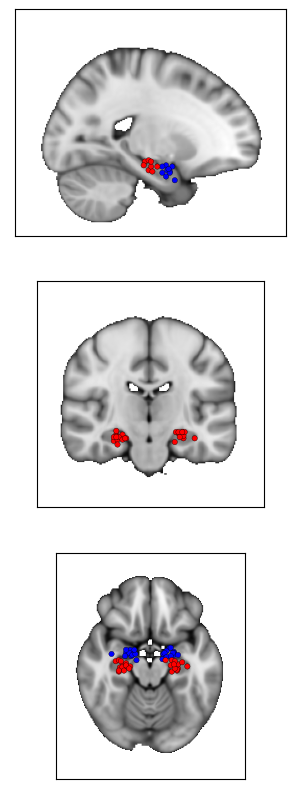

In [57]:
figure_dir=f"/Users/kamp/PhD/spikevar/repo/SpikeVar/figures"
position_file=f"{figure_dir}/electrodePos_clean.csv"
positions = pd.read_csv(position_file, sep=";")

# prepare positions data frame
positions[positions=="n/a "] = np.NAN
n_patients = len(positions)
brain_regions = positions.columns[1:]

positions = positions.melt(id_vars="Patient ID", var_name="region", value_name="coordinates")
positions.region = positions.region.str.strip()
coordinates = positions.coordinates.str.split(",", expand=True)
coordinates.columns = list("xyz")
positions = positions.join(coordinates.astype(float))

coordinates_array = [np.array(positions.coordinates[i].split(',')).astype(float) 
    if isinstance(positions.coordinates[i], str) else np.repeat(np.NAN,3) 
    for i in range(len(positions))]
positions['mni_coordinates'] = coordinates_array

# load 1 mm brain MNI
mni_path = "/usr/local/fsl/data/standard/MNI152_T1_1mm_brain.nii.gz"
mni_image = nib.load(mni_path)
mni_data = mni_image.get_fdata()
aff = mni_image.affine

# get voxel coordinates
def convert2voxel(mni_coordinates): 
    if np.isnan(mni_coordinates[0]):
        return np.repeat(np.nan,3)
    voxel_coor = nib.affines.apply_affine(np.linalg.inv(aff), mni_coordinates)
    return voxel_coor.astype(int)
positions['voxel_coordinates'] = positions.mni_coordinates.apply(convert2voxel)

x_pos, y_pos, z_pos = [111, 107, 55] # coordinates in voxel coordinates (have to be in the mm scale as mni image)

def plot_positions(positions, x_pos, y_pos, z_pos): 
    fig, ax = plt.subplots(3,1, figsize=(5,10))
    # scatter plot setting
    s = 15 
    lw = 0.25
    color_dict = {"L Amygdala": "blue", "R Amygdala": "blue", "L Hippocampus": "red", "R Hippocampus": "red"}
    
    # saggital
    mni_slice = mni_data[x_pos, :, :]
    mni_slice[np.isclose(mni_slice,0)]=np.max(mni_slice)-10
    ax[0].imshow(mni_slice.T, cmap="gray", origin="lower")
    scatter = pd.DataFrame([dict(region=positions.region[i], x = positions.voxel_coordinates[i][0], y=positions.voxel_coordinates[i][1], z=positions.voxel_coordinates[i][2], 
        distance = abs(positions.voxel_coordinates[i][0]-x_pos)) 
        for i in range(len(positions)) if abs(positions.voxel_coordinates[i][0]-x_pos)<2]) 
    scatter['color'] = [color_dict[scatter.region[i]] for i in range(len(scatter))]
    ax[0].scatter(x=scatter.y, y=scatter.z, c=scatter.color, s=s, edgecolors='black', linewidths=lw)

    # coronal
    mni_slice = mni_data[:, y_pos, :]
    mni_slice[np.isclose(mni_slice,0)]=np.max(mni_slice)-10
    ax[1].imshow(mni_slice.T, cmap="gray", origin="lower")
    scatter = pd.DataFrame([dict(region=positions.region[i], x = positions.voxel_coordinates[i][0], y=positions.voxel_coordinates[i][1], z=positions.voxel_coordinates[i][2], 
        distance = abs(positions.voxel_coordinates[i][1]-y_pos)) 
        for i in range(len(positions)) if abs(positions.voxel_coordinates[i][1]-y_pos)<2])
    scatter['color'] = [color_dict[scatter.region[i]] for i in range(len(scatter))]
    ax[1].scatter(x=scatter.x, y=scatter.z, c=scatter.color, s=s, edgecolors='black',linewidths=lw)
    
    # axial
    mni_slice = mni_data[:, :, z_pos]
    mni_slice[np.isclose(mni_slice,0)]=np.max(mni_slice)-10
    ax[2].imshow(mni_slice.T, cmap="gray", origin="lower")
    scatter = pd.DataFrame([dict(region=positions.region[i], x = positions.voxel_coordinates[i][0], y=positions.voxel_coordinates[i][1], z=positions.voxel_coordinates[i][2], 
        distance = abs(positions.voxel_coordinates[i][2]-z_pos)) 
        for i in range(len(positions)) if abs(positions.voxel_coordinates[i][2]-z_pos)<2])
    scatter['color'] = [color_dict[scatter.region[i]] for i in range(len(scatter))]
    ax[2].scatter(x=scatter.x, y=scatter.y, c=scatter.color, s=s, edgecolors='black',linewidths=lw)
     
    for i in range(3):
        ax[i].set_xticks([]),ax[i].set_yticks([])
    return fig

fig = plot_positions(positions, x_pos, y_pos, z_pos)
fig.savefig("electrode_positions.pdf", bbox_inches="tight")


# Plot electrode positions as scatter and choose field of view

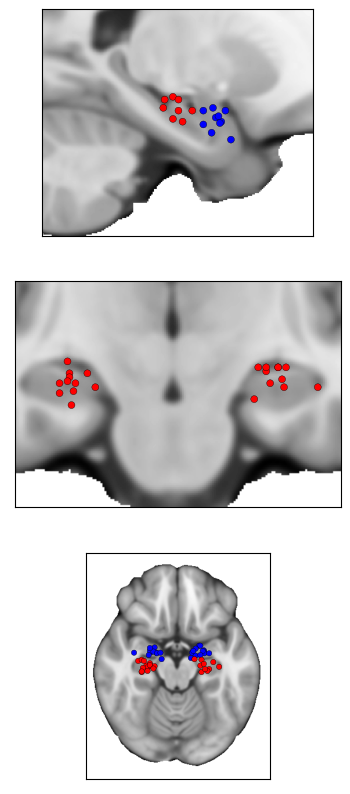

In [13]:
figure_dir=f"/Users/kamp/PhD/spikevar/repo/SpikeVar/figures"
position_file=f"{figure_dir}/electrodePos_clean.csv"
positions = pd.read_csv(position_file, sep=";")

# prepare positions data frame
positions[positions=="n/a "] = np.NAN
n_patients = len(positions)
brain_regions = positions.columns[1:]

positions = positions.melt(id_vars="Patient ID", var_name="region", value_name="coordinates")
positions.region = positions.region.str.strip()
coordinates = positions.coordinates.str.split(",", expand=True)
coordinates.columns = list("xyz")
positions = positions.join(coordinates.astype(float))

coordinates_array = [np.array(positions.coordinates[i].split(',')).astype(float) 
    if isinstance(positions.coordinates[i], str) else np.repeat(np.NAN,3) 
    for i in range(len(positions))]
positions['mni_coordinates'] = coordinates_array

# load 1 mm brain MNI
mni_path = "/Users/kamp/PhD/spikevar/data/neuro/MNI152_T1_0.5mm_brain.nii.gz"
mni_image = nib.load(mni_path)
mni_data = mni_image.get_fdata()
aff = mni_image.affine

# get voxel coordinates
def convert2voxel(mni_coordinates): 
    if np.isnan(mni_coordinates[0]):
        return np.repeat(np.nan,3)
    voxel_coor = nib.affines.apply_affine(np.linalg.inv(aff), mni_coordinates)
    return voxel_coor.astype(int)
positions['voxel_coordinates'] = positions.mni_coordinates.apply(convert2voxel)

x_pos, y_pos, z_pos = np.array([111, 107, 55])*2 # coordinates in voxel coordinates (have to be in the mm scale as mni image)

def plot_positions(positions, x_pos, y_pos, z_pos): 
    fig, ax = plt.subplots(3,1, figsize=(5,10))
    # scatter plot setting
    s = 25 
    lw = 0.25
    color_dict = {"L Amygdala": "blue", "R Amygdala": "blue", "L Hippocampus": "red", "R Hippocampus": "red"}
    
    # saggital
    mni_slice = mni_data[x_pos, :, :]
    mni_slice[np.isclose(mni_slice,0)]=np.max(mni_slice)
    x_start, x_end = 120, 120  # choose field of view
    y_start, y_end = 20, 180  
    ax[0].imshow(mni_slice[x_start:-x_end,y_start:-y_end].T, cmap="gray", origin="lower")
    
    scatter = pd.DataFrame([dict(region=positions.region[i], x = positions.voxel_coordinates[i][0], y=positions.voxel_coordinates[i][1], z=positions.voxel_coordinates[i][2], 
        distance = abs(positions.voxel_coordinates[i][0]-x_pos)) 
        for i in range(len(positions)) if abs(positions.voxel_coordinates[i][0]-x_pos)<3]) 
    scatter['color'] = [color_dict[scatter.region[i]] for i in range(len(scatter))]
    ax[0].scatter(x=scatter.y - x_start, y=scatter.z - y_start, c=scatter.color, s=s, edgecolors='black', linewidths=lw)

    # coronal
    mni_slice = mni_data[:, y_pos, :]
    mni_slice[np.isclose(mni_slice,0)]=np.max(mni_slice)
    x_start, x_end = 100, 100  
    y_start, y_end = 50, 200   
    ax[1].imshow(mni_slice[x_start:-x_end,y_start:-y_end].T, cmap="gray", origin="lower")

    scatter = pd.DataFrame([dict(region=positions.region[i], x = positions.voxel_coordinates[i][0], y=positions.voxel_coordinates[i][1], z=positions.voxel_coordinates[i][2], 
        distance = abs(positions.voxel_coordinates[i][1]-y_pos)) 
        for i in range(len(positions)) if abs(positions.voxel_coordinates[i][1]-y_pos)<3])
    scatter['color'] = [color_dict[scatter.region[i]] for i in range(len(scatter))]
    ax[1].scatter(x=scatter.x - x_start, y=scatter.z - y_start, c=scatter.color, s=s, edgecolors='black',linewidths=lw)
    
    # axial
    mni_slice = mni_data[:, :, z_pos]
    mni_slice[np.isclose(mni_slice,0)]=np.max(mni_slice)
    x_start, x_end = 25, 25   
    y_start, y_end = 25, 25  
    ax[2].imshow(mni_slice[x_start:-x_end,y_start:-y_end].T, cmap="gray", origin="lower")
    
    scatter = pd.DataFrame([dict(region=positions.region[i], x = positions.voxel_coordinates[i][0], y=positions.voxel_coordinates[i][1], z=positions.voxel_coordinates[i][2], 
        distance = abs(positions.voxel_coordinates[i][2]-z_pos)) 
        for i in range(len(positions)) if abs(positions.voxel_coordinates[i][2]-z_pos)<3])
    scatter['color'] = [color_dict[scatter.region[i]] for i in range(len(scatter))]
    ax[2].scatter(x=scatter.x - x_start, y=scatter.y - y_start, c=scatter.color, s=15, edgecolors='black',linewidths=lw)
     
    for i in range(3):
        ax[i].set_xticks([]),ax[i].set_yticks([])
    return fig

fig = plot_positions(positions, x_pos, y_pos, z_pos)
fig.savefig("electrode_positions.pdf", bbox_inches="tight")